In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from toy_plot_helpers import ToyPlot

In [2]:
import openpathsampling.engines.toy as toys

plot = ToyPlot()
pes = (
    toys.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [-0.5, 0.5]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])
)

plot.contour_range = np.arange(-1.5, 1.0, 0.1)

topology=toys.Topology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

template = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    topology=topology
)

integ = toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'nsteps_per_frame' : 10
}

toy_eng = toys.Engine(
    options=options,
    template=template
)
toy_eng.initialized = True

toy_eng.current_snapshot = template
paths.PathMover.engine = toy_eng

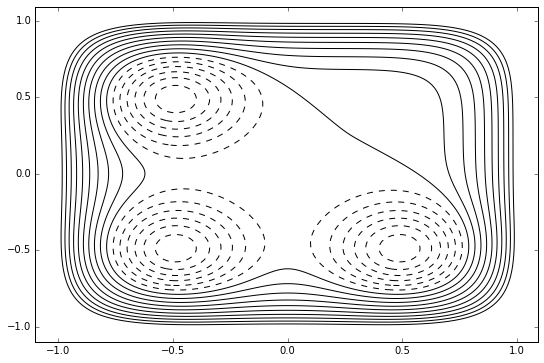

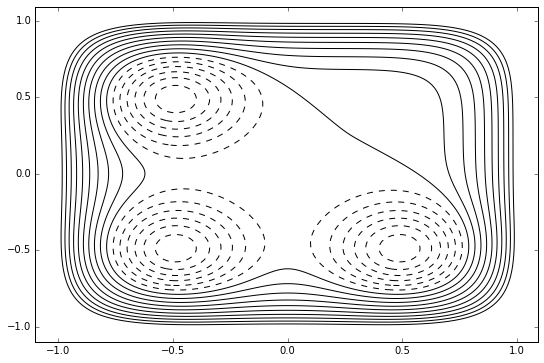

In [3]:
plot.add_pes(pes)
plot.plot()

In [4]:
def xval(snapshot):
    return snapshot.xyz[0][0]

def xprime(snapshot):
    # this only exists until we set up the ability for the order parameter to decrease
    return -snapshot.xyz[0][0]

def yval(snapshot):
    return snapshot.xyz[0][1]
    
opX = paths.CV_Function(name="opX", f=xval)
opY = paths.CV_Function(name="opY", f=yval)
opXprime = paths.CV_Function(name="opXprime", f=xprime)

In [5]:
x_under_min = paths.CVRangeVolume(opX, float("-inf"), -0.3)
x_over_max = paths.CVRangeVolume(opX, 0.3, float("inf")) 
y_under_min = paths.CVRangeVolume(opY, float("-inf"), -0.3)
y_over_max = paths.CVRangeVolume(opY, 0.3, float("inf")) 

stateA = (x_under_min & y_under_min).named("A")
stateB = (x_over_max & y_under_min).named("B")
stateC = (x_under_min & y_over_max).named("C")

In [6]:
#plot.add_states([stateA, stateB, stateC])
#plot.plot()

In [7]:
interfacesAB = paths.VolumeInterfaceSet(opX, float("-inf"), [-0.3, -0.2, -0.1, 0.0])
interfacesAC = paths.VolumeInterfaceSet(opY, float("-inf"), [-0.3, -0.2, -0.1, 0.0])
interfacesBA = paths.VolumeInterfaceSet(opXprime, float("-inf"), [-0.3, -0.2, -0.1, 0.0])

In [8]:
mistis = paths.MISTISNetwork([
    (stateA, interfacesAB, stateB),
    (stateA, interfacesAC, stateC),
    (stateB, interfacesBA, stateA)
])

In [9]:
scheme = paths.DefaultScheme(mistis, engine=toy_eng)

In [10]:
tisAB = mistis.transitions[(stateA, stateB)]
tisAC = mistis.transitions[(stateA, stateC)]
tisBA = mistis.transitions[(stateB, stateA)]

In [11]:
import logging.config
logging.config.fileConfig("debug_logging.conf", disable_existing_loggers=False)

In [12]:
snapA = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]),
    velocities=np.array([[0.5, 0.0]])
)
init_AB = paths.FullBootstrapping(
    transition=tisAB, 
    snapshot=snapA, 
    engine=toy_eng, 
    forbidden_states=[stateC],
    extra_ensembles=mistis.ms_outers
).run()

DONE! Completed Bootstrapping cycle step 110 in ensemble 4/4.


In [13]:
snapA = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]),
    velocities=np.array([[0.0, 0.5]])
)
init_AC = paths.FullBootstrapping(
    transition=tisAC, 
    snapshot=snapA, 
    engine=toy_eng, 
    forbidden_states=[stateB]
).run()

DONE! Completed Bootstrapping cycle step 258 in ensemble 4/4.


In [14]:
snapB = toys.Snapshot(
    coordinates=np.array([[0.5, -0.5]]),
    velocities=np.array([[-0.5, 0.0]])
)
init_BA = paths.FullBootstrapping(
    transition=tisBA, 
    snapshot=snapB, 
    engine=toy_eng, 
    forbidden_states=[stateC]
).run()

DONE! Completed Bootstrapping cycle step 20 in ensemble 3/3.


In [15]:
initial_trajectories = [s.trajectory for s in list(init_AB)+list(init_AC)+list(init_BA)]

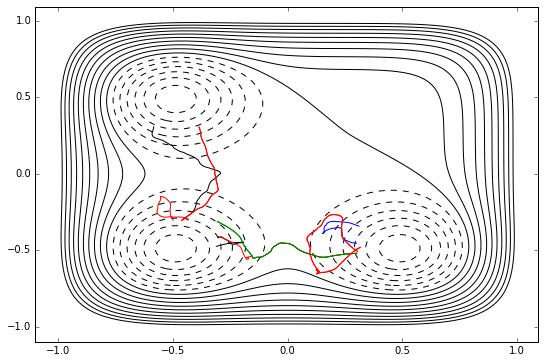

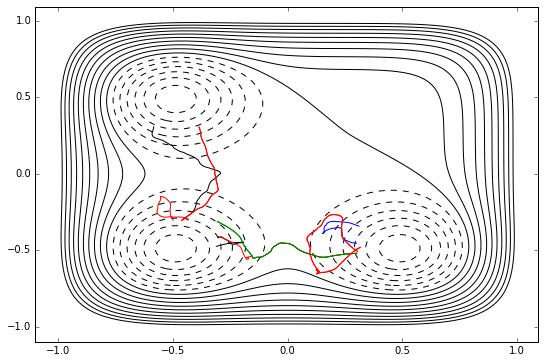

In [16]:
plot.plot(initial_trajectories)

In [17]:
sset = scheme.initial_conditions_from_trajectories(initial_trajectories)
print scheme.initial_conditions_report(sset)

Missing ensembles:
*  [[MinusInterfaceEnsemble]]
*  [[MinusInterfaceEnsemble]]
No extra ensembles.



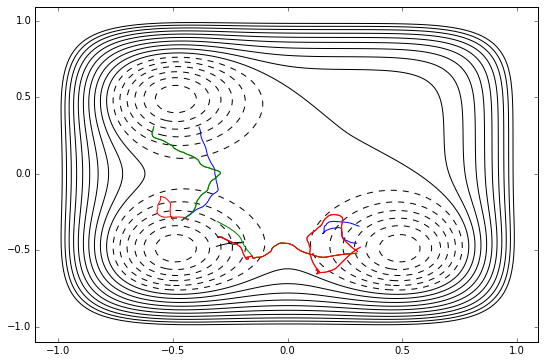

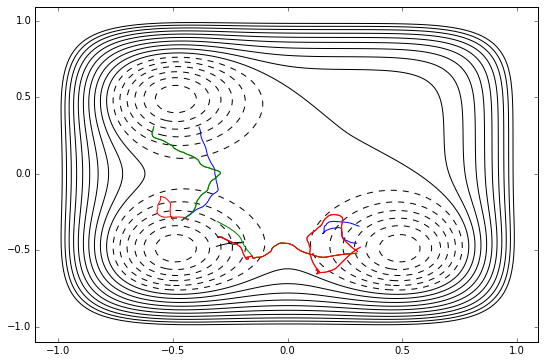

In [18]:
plot.plot([s.trajectory for s in sset])

In [20]:
minus_samples = []
for minus in mistis.minus_ensembles:
    samp = minus.populate_minus_ensemble_from_set(
        samples=sset,
        minus_replica_id=-mistis.minus_ensembles.index(minus)-1,
        engine=toy_eng
    )
    minus_samples.append(samp)

sset = sset.apply_samples(minus_samples)
print scheme.initial_conditions_report(sset)

No missing ensembles.
No extra ensembles.



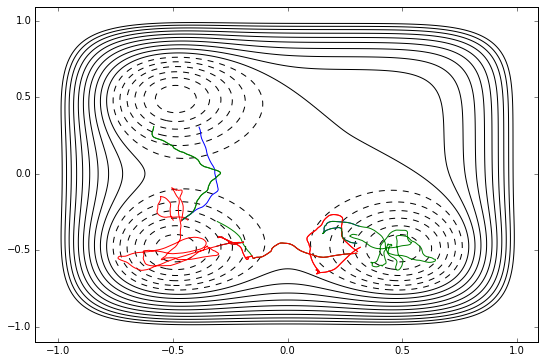

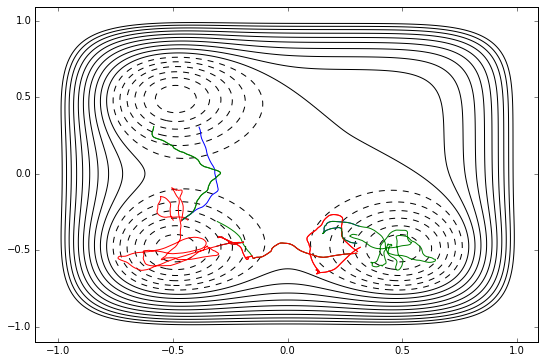

In [21]:
plot.plot([s.trajectory for s in sset])

In [22]:
#logging.config.fileConfig("debug_logging.conf", disable_existing_loggers=False)
storage = paths.Storage("mistis.nc", "w", template=template)

In [23]:
mistis_calc = paths.PathSampling(
    storage=storage,
    move_scheme=scheme,
    globalstate=sset
)
mistis_calc.save_frequency = 100

In [24]:
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)
mistis_calc.run(400)


Working on Monte Carlo cycle number 400.
DONE! Completed 400 Monte Carlo cycles.


In [ ]:
#! skip
# skip this during testing; leave for full calculation
mistis_calc.run_until(10000)